In [3]:
'''
Github Reference:
https://github.com/ParrotPrediction/docker-course-xgboost/blob/master/notebooks/3.%20Going%20deeper/3.2%20Bias-variance%20tradeoff.ipynb
Youtube Reference:
https://www.youtube.com/watch?v=R5eJgjn9bnw
'''
%matplotlib inline

import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.learning_curve import validation_curve
from sklearn.datasets import load_svmlight_files
from sklearn.cross_validation import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

# reproducibility
seed = 123
np.random.seed(seed)

In [4]:
# Now generate artificial dataset
X, y = make_classification(
    n_samples=1000, n_features=20, 
    n_informative=8, n_redundant=3, n_repeated=2, 
    random_state=seed)

In [5]:
X.shape

(1000, 20)

In [6]:
#We will divide into 10 stratified folds (the same distibution of labels in each fold) for testing
cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=seed)
cv

sklearn.cross_validation.StratifiedKFold(labels=[1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1
 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0
 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0
 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 1 0
 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0
 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0
 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0
 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0
 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 1
 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1

In [7]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': 1.0
}

#Return evenly spaced numbers over a specified interval.
n_estimators_range = np.linspace(start = 1, stop = 200, num =10).astype('int') 



train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)
n_estimators_range

array([  1,  23,  45,  67,  89, 111, 133, 155, 177, 200])

In [8]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


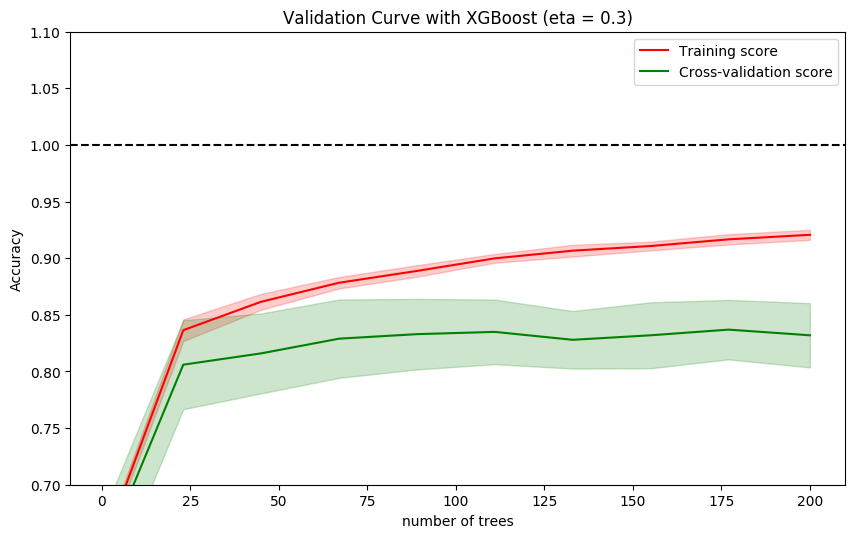

Best cross-validation result (0.84) obtained for 177 trees


In [9]:
fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean) # best index

'''
Looking at the plot we can draw the following conclusions:

1.training score keeps growing while adding new trees, but from a certain point CV score is fixed
2. variance is lowest, and bias is high for less than 25 trees,
3.from about 25 trees, the variance is getting higher and while the CV score bias is holding steady (there is no point for adding extra trees / complexity)
we can see that the model is quite stable keeping variance fixed when increasing it's complexity
4.We can assume that the trade-off for our model will be met at n_estimators = 50. The variance is still to big.
'''
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))


In [13]:
n_estimators_range = np.linspace(start = 50, stop = 1000, num = 10).astype('int') 
n_estimators_range

array([  50,  155,  261,  366,  472,  577,  683,  788,  894, 1000])